In [1]:
import numpy as np
import csv
import cv2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Cropping2D
from keras.layers import Convolution2D
from keras.layers.core import Lambda
from keras.callbacks import ModelCheckpoint
from keras.layers.pooling import MaxPooling2D
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
lines=[]
with open('./data/driving_log.csv') as csvfile:
    next(csvfile)
    reader=csv.reader(csvfile)
    #reader=csvfile.readline()[1:]
    for line in reader:
        lines.append(line)
      


    
from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(lines, test_size=0.2)

In [3]:
def generator(samples,batch_size=16):
    num_samples=len(samples)
    #print(num_samples)
    while True:
        shuffle(samples)
        for offset in range(0,num_samples,batch_size):
            
            batch_samples=samples[offset:offset+batch_size]
            #print(batch_samples)
            img_center=[]
            img_left=[]
            img_right=[]
            images=[]
            
            measurements=[]
            left_angle=[]
            right_angle=[]        
            for batch_sample in batch_samples:
                #for i in range(3):
                steering_center=float(batch_sample[3])
                correction = 0.24
                #print(batch_sample)
                steering_left = steering_center + correction
                steering_right = steering_center - correction

                source_path=batch_sample[0]
                filename=source_path.split('/')[-1]
                current_path='./data/IMG/'+filename

                
                images.append(cv2.imread(current_path))
                images.append(cv2.flip(cv2.imread(current_path),1))
                measurements.append(steering_center)
                measurements.append(steering_center*-1)
                
                source_path=batch_sample[1]
                filename=source_path.split('/')[-1]
                current_path='./data/IMG/'+filename
                images.append(cv2.imread(current_path))
                images.append(cv2.flip(cv2.imread(current_path),1))
                measurements.append(steering_left)
                measurements.append(steering_left*-1)
                
                source_path=batch_sample[2]
                filename=source_path.split('/')[-1]
                current_path='./data/IMG/'+filename
                images.append(cv2.imread(current_path))
                images.append(cv2.flip(cv2.imread(current_path),1))
                measurements.append(steering_right)
                measurements.append(steering_right*-1)
            X_train = np.array(images)
            y_train = np.array(measurements)
            
            if(offset==0):
                plt.figure(figsize=(8,8))
                for i in range(6):
                    image =X_train[i].squeeze() 
                    plt.imshow(image.squeeze())
                    plt.subplot(3,2,i+1)
                    plt.imshow(image,cmap="gray")

                plt.show()
            #print(y_train)
            yield X_train, y_train
            

train_generator = generator(train_samples, batch_size=16)
validation_generator = generator(validation_samples, batch_size=16)

In [4]:
def Nvidia(keep_probs):
    
    model=Sequential()
    
    model.add(Lambda(lambda x:x/255.0-0.5,input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,20),(0,0))))
    model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D(32,5,5,subsample=(2,2),activation="relu"))
    #model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
    #model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Convolution2D(64,3,3,activation="relu"))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D(64,3,3,activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(keep_probs))
    model.add(Flatten())
    
   
    model.add(Activation('relu'))

    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))

    model.summary()

    return model

model=Nvidia(0.2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 70, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 33, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 15, 77, 32)    19232       convolution2d_1[0][0]            
___________________________________________________________________________________________

Epoch 1/3


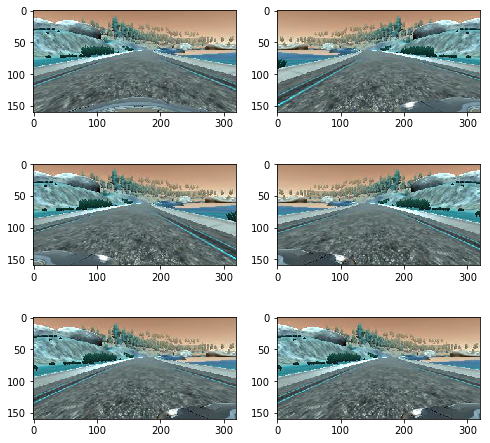

12768/12856 [============================>.] - ETA: 0s - loss: 0.0267

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


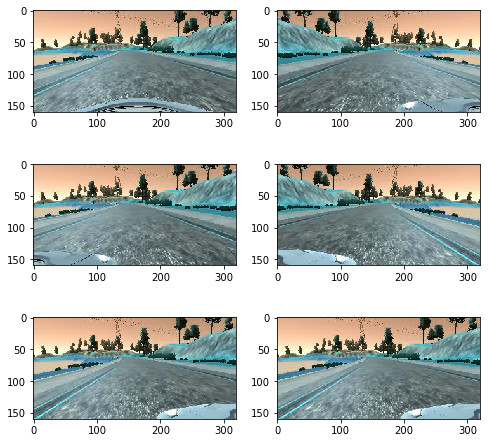

12864/12856 [==============================] - 28s - loss: 0.0267 - val_loss: 0.0212
Epoch 2/3
12864/12856 [==============================] - 24s - loss: 0.0208 - val_loss: 0.0160
Epoch 3/3
12384/12856 [===========================>..] - ETA: 0s - loss: 0.0163

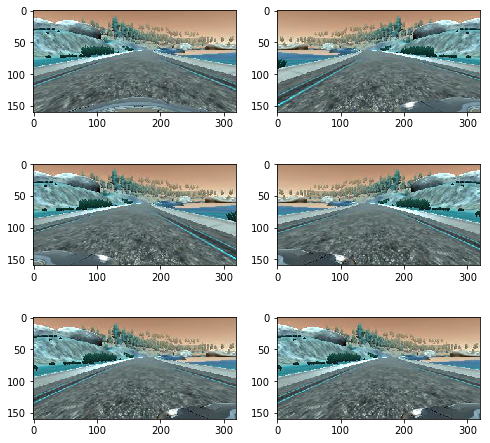

12840/12856 [============================>.] - ETA: 0s - loss: 0.0162

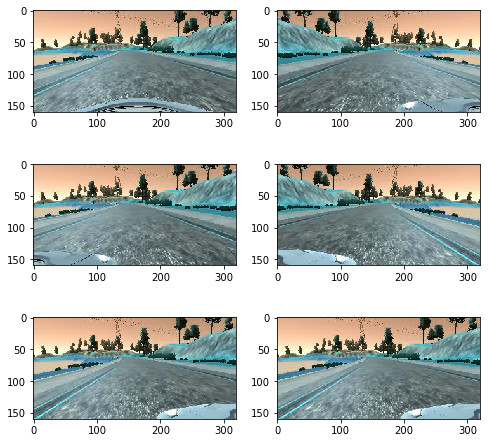

12936/12856 [==============================] - 26s - loss: 0.0162 - val_loss: 0.0131


In [5]:
#save the best model in a checkpoint
checkpoint=ModelCheckpoint('model-{epoch:03d}.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

model.compile(loss='mse', optimizer='adam')

model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*2, validation_data=validation_generator, nb_val_samples=len(validation_samples)*2, nb_epoch=3,callbacks=[checkpoint],verbose=1)

model.save('model.h5')

Epoch 1/4
12768/12856 [============================>.] - ETA: 0s - loss: 0.0124

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


12864/12856 [==============================] - 24s - loss: 0.0123 - val_loss: 0.0087
Epoch 2/4
12864/12856 [==============================] - 24s - loss: 0.0118 - val_loss: 0.0126
Epoch 3/4
11424/12856 [=========================>....] - ETA: 2s - loss: 0.0130

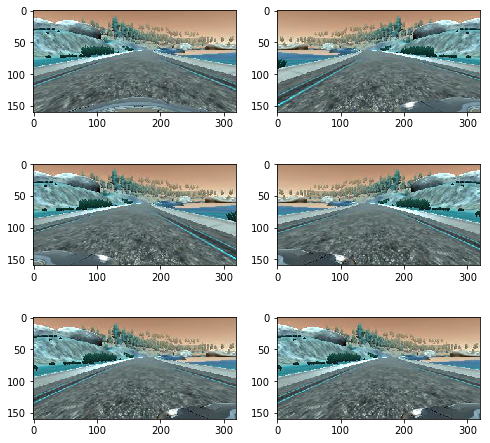

12840/12856 [============================>.] - ETA: 0s - loss: 0.0129

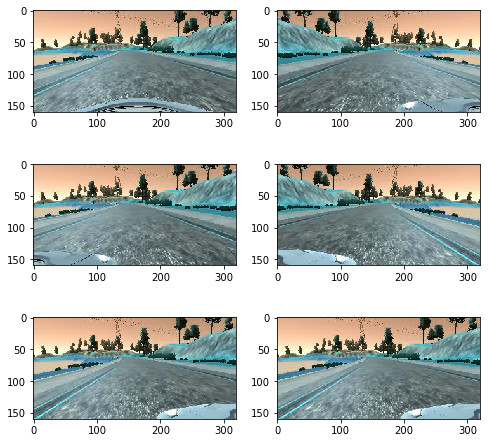

12936/12856 [==============================] - 26s - loss: 0.0128 - val_loss: 0.0109
Epoch 4/4
12864/12856 [==============================] - 24s - loss: 0.0103 - val_loss: 0.0082
dict_keys(['val_loss', 'loss'])


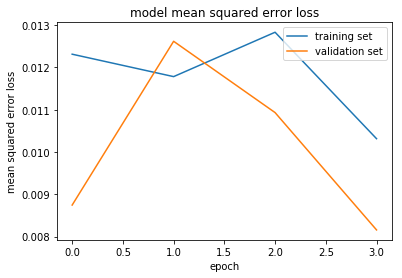

In [6]:
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples)*2, validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples)*2, 
    nb_epoch=4, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()